
# Classificação de Imagens: Cachorro vs Lobo

Este notebook implementa um modelo para classificar imagens entre as classes "Cachorro" e "Lobo". Utiliza a biblioteca TensorFlow para a construção e treinamento de uma rede neural baseada no ResNet50, incluindo etapas de:
- Preparação dos dados
- Construção do modelo
- Treinamento e análise de resultados

Autores:
- Daniel Santos
- Eduardo Candioto
- Laura Cecilia
- Rodrigo Victor


In [ ]:
#Baixando Dataset Cachorro X Lobo
!kaggle datasets download harishvutukuri/dogs-vs-wolves

Dataset URL: https://www.kaggle.com/datasets/harishvutukuri/dogs-vs-wolves
License(s): DbCL-1.0
100% 222M/222M [00:10<00:00, 27.8MB/s]
100% 222M/222M [00:10<00:00, 21.6MB/s]


In [ ]:

import os
import shutil
import random
import zipfile
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

# Descompacta os dados do arquivo ZIP
with zipfile.ZipFile("dogs-vs-wolves.zip", 'r') as zip_ref:
    zip_ref.extractall("dogs-vs-wolves")

# Diretórios base
dataset_dir = 'dogs-vs-wolves/data'
train_dir = 'dogs-vs-wolves/train'
validation_dir = 'dogs-vs-wolves/validation'

# Função para limpar e criar diretórios
def clear_and_create_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

# Configuração de diretórios para treino e validação
clear_and_create_dir(train_dir)
clear_and_create_dir(validation_dir)
os.makedirs(os.path.join(train_dir, 'dogs'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'wolves'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'dogs'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'wolves'), exist_ok=True)

# Divisão dos dados em treino (70%) e validação (30%)
for animal in ['dogs', 'wolves']:
    animal_dir = os.path.join(dataset_dir, animal)
    images = os.listdir(animal_dir)
    random.shuffle(images)
    train_count = int(len(images) * 0.7)

    for img in images[:train_count]:
        shutil.copy(os.path.join(animal_dir, img), os.path.join(train_dir, animal, img))
    for img in images[train_count:]:
        shutil.copy(os.path.join(animal_dir, img), os.path.join(validation_dir, animal, img))


In [ ]:

# Configuração de data augmentation para as imagens de treino
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalização das imagens
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalização simples para os dados de validação
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Geração dos conjuntos de treino e validação
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

# Carrega o modelo base ResNet50 pré-treinado e congela os pesos
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Construção do modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1, activation='sigmoid')
])

# Compilação do modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Found 1400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:

# Configuração de callbacks
checkpoint_path = "best_model.keras"
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')

# Callback para cálculo de métricas adicionais
class MetricsLogger(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.precisions = []
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.validation_data.classes
        y_pred = (self.model.predict(self.validation_data) > 0.5).astype(int)
        precision = precision_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        self.precisions.append(precision)
        self.f1_scores.append(f1)
        print(f"Epoch {epoch + 1} - Precision: {precision:.4f}, F1-Score: {f1:.4f}")

metrics_logger = MetricsLogger(validation_data=validation_generator)

# Treinamento inicial
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint, metrics_logger]
)

# Descongela parte do modelo base para fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Compilação do modelo com nova taxa de aprendizado
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tuning do modelo
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stopping, model_checkpoint, metrics_logger]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step
Epoch 1 - Precision: 0.4189, F1-Score: 0.1658
88/88 ━━━━━━━━━━━━━━━━━━━━ 517s 6s/step - accuracy: 0.5416 - loss: 2.6679 - val_accuracy: 0.4800 - val_loss: 0.8246
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step
Epoch 2 - Precision: 0.0000, F1-Score: 0.0000
88/88 ━━━━━━━━━━━━━━━━━━━━ 529s 6s/step - accuracy: 0.5568 - loss: 0.8236 - val_accuracy: 0.5000 - val_loss: 0.7839
Epoch 3/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


38/38 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step
Epoch 3 - Precision: 0.5025, F1-Score: 0.6659
88/88 ━━━━━━━━━━━━━━━━━━━━ 497s 6s/step - accuracy: 0.5569 - loss: 0.7655 - val_accuracy: 0.5117 - val_loss: 0.8425
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step
Epoch 4 - Precision: 0.4953, F1-Score: 0.6330
88/88 ━━━━━━━━━━━━━━━━━━━━ 538s 6s/step - accuracy: 0.5170 - loss: 0.7958 - val_accuracy: 0.5450 - val_loss: 0.7347
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step
Epoch 5 - Precision: 0.5000, F1-Score: 0.6614
88/88 ━━━━━━━━━━━━━━━━━━━━ 525s 6s/step - accuracy: 0.5185 - loss: 0.7404 - val_accuracy: 0.5133 - val_loss: 0.7813
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step
Epoch 6 - Precision: 0.0000, F1-Score: 0.0000
88/88 ━━━━━━━━━━━━━━━━━━━━ 527s 6s/step - accuracy: 0.5442 - loss: 0.7501 - val_accuracy: 0.5000 - val_loss: 0.7507
Epoch 7/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


38/38 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step
Epoch 7 - Precision: 0.5000, F1-Score: 0.5114
88/88 ━━━━━━━━━━━━━━━━━━━━ 561s 6s/step - accuracy: 0.5274 - loss: 0.7299 - val_accuracy: 0.5733 - val_loss: 0.7065
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step
Epoch 8 - Precision: 0.5217, F1-Score: 0.3967
88/88 ━━━━━━━━━━━━━━━━━━━━ 565s 6s/step - accuracy: 0.5696 - loss: 0.7137 - val_accuracy: 0.5367 - val_loss: 0.7085
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step
Epoch 9 - Precision: 0.5111, F1-Score: 0.6365
88/88 ━━━━━━━━━━━━━━━━━━━━ 529s 6s/step - accuracy: 0.5458 - loss: 0.7175 - val_accuracy: 0.5583 - val_loss: 0.7053
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step
Epoch 10 - Precision: 0.5071, F1-Score: 0.4897
88/88 ━━━━━━━━━━━━━━━━━━━━ 534s 6s/step - accuracy: 0.5686 - loss: 0.7014 - val_accuracy: 0.5633 - val_loss: 0.7023
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step
Epoch 10 - Precision: 0.5089, F1-Score: 0.6096
88/88 ━━━━━━━━━━━━━━━━━━━━ 581s 7s/step - accuracy: 0.5695

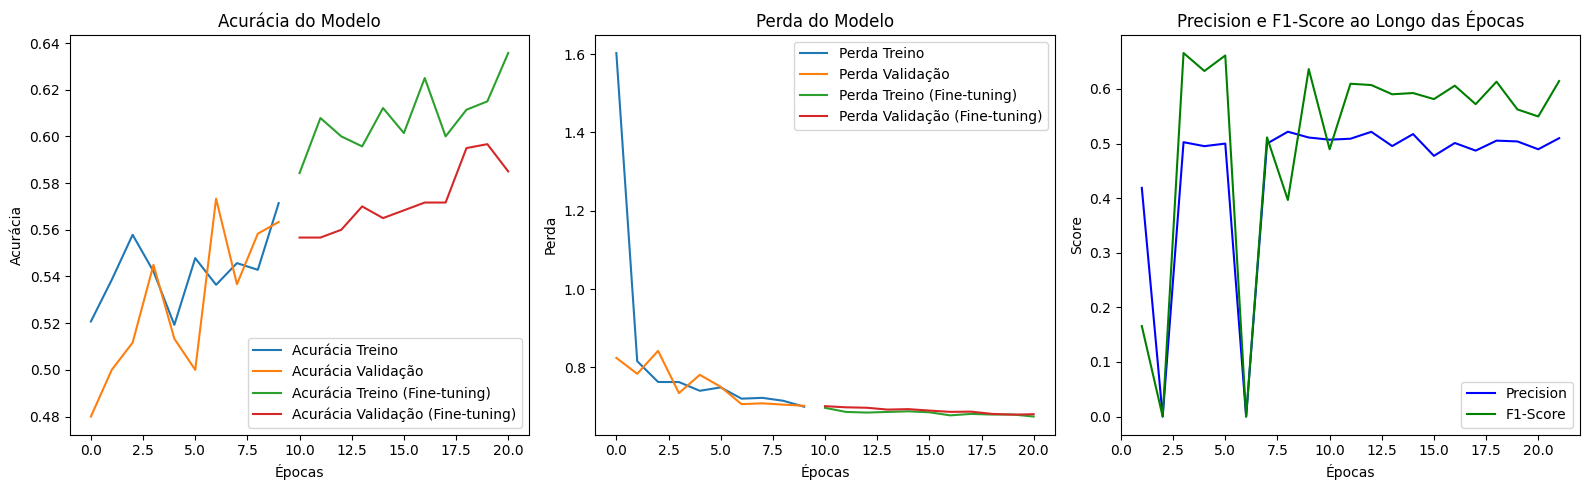

In [ ]:

# Função para plotar os resultados
def plot_history_with_metrics(history, history_fine=None, metrics_logger=None):
    plt.figure(figsize=(16, 5))

    # Gráfico de acurácia
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')

    if history_fine is not None:
        fine_epochs = range(len(history.history['accuracy']), len(history.history['accuracy']) + len(history_fine.history['accuracy']))
        plt.plot(fine_epochs, history_fine.history['accuracy'], label='Acurácia Treino (Fine-tuning)')
        plt.plot(fine_epochs, history_fine.history['val_accuracy'], label='Acurácia Validação (Fine-tuning)')

    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend(loc='lower right')
    plt.title('Acurácia do Modelo')

    # Gráfico de perda
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Perda Treino')
    plt.plot(history.history['val_loss'], label='Perda Validação')

    if history_fine is not None:
        plt.plot(fine_epochs, history_fine.history['loss'], label='Perda Treino (Fine-tuning)')
        plt.plot(fine_epochs, history_fine.history['val_loss'], label='Perda Validação (Fine-tuning)')

    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend(loc='upper right')
    plt.title('Perda do Modelo')

    # Gráfico de métricas adicionais
    if metrics_logger is not None:
        plt.subplot(1, 3, 3)
        epochs = range(1, len(metrics_logger.precisions) + 1)
        plt.plot(epochs, metrics_logger.precisions, label='Precision', color='blue')
        plt.plot(epochs, metrics_logger.f1_scores, label='F1-Score', color='green')
        plt.xlabel('Épocas')
        plt.ylabel('Score')
        plt.legend(loc='lower right')
        plt.title('Precision e F1-Score ao Longo das Épocas')

    plt.tight_layout()
    plt.show()

# Plotagem dos resultados
plot_history_with_metrics(history, history_fine, metrics_logger)
